In [1]:
import xarray as xr
from analysis.utils import GlobalPlotter
import os.path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from cartopy.crs import PlateCarree, EqualEarth
%env GOOGLE_APPLICATION_CREDENTIALS /home/ag7531/access_key.json
%matplotlib notebook


env: GOOGLE_APPLICATION_CREDENTIALS=/home/ag7531/access_key.json


In [2]:
path_to_data = '/scratch/ag7531/paper_plots_data'

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This is the class used for map plots. If you just want to change args passed to plots, you don't need to modify this directly, but rather modify the arg lists (see further on)

In [3]:
import numpy as np
import mlflow
from mlflow.tracking import client
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import pandas as pd
from analysis.analysis import TimeSeriesForPoint
import xarray as xr
from scipy.ndimage import gaussian_filter
from data.pangeo_catalog import get_patch, get_whole_data
from cartopy.crs import PlateCarree, EqualEarth


from enum import Enum

CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'

class GlobalPlotter:
    """General class to make plots for global data. Handles masking of
    continental data + showing a band near coastlines."""

    def __init__(self, margin: int = 2, cbar: bool = True, ice: bool = True):
        self.mask = self._get_global_u_mask()
        self.margin = margin
        self.cbar = cbar
        self.ticks = dict(x=None, y=None)
        self.ice = ice

    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, value):
        self._mask = value

    @property
    def borders(self):
        return self._borders

    @borders.setter
    def borders(self, value):
        self._borders = value

    @property
    def margin(self):
        return self._margin

    @margin.setter
    def margin(self, margin):
        self._margin = margin
        self.borders = self._get_continent_borders(self.mask, self.margin)

    @property
    def x_ticks(self):
        return self.ticks['x']

    @x_ticks.setter
    def x_ticks(self, value):
        self.ticks['x'] = value

    @property
    def y_ticks(self):
        return self.ticks['y']

    @y_ticks.setter
    def y_ticks(self, value):
        self.ticks['y'] = value

    def plot(self, u: xr.DataArray = None, projection_cls=PlateCarree,
             lon: float = -100.0, lat: float = None, ax=None, animated=False,
             borders_color='grey', borders_alpha=1.,
             colorbar_label='', **plot_func_kw):
        """
        Plots the passed velocity component on a map, using the specified
        projection. Uses the instance's mask to set as nan some values.
        Parameters
        ----------
        u : xr.DataArray
            Velocity array. The default is None.
        projection : Projection
            Projection used for the 2D plot.
        lon : float, optional
            Central longitude. The default is -100.0.
        lat : float, optional
            Central latitude. The default is None.
        Returns
        -------
        None.
        """
        fig = plt.figure()
        projection = projection_cls(lon)
        if ax is None:
            ax = plt.axes(projection=projection)
            plt.rc('axes',facecolor='black')
            plt.rc('axes',edgecolor='k')
        mesh_x, mesh_y = np.meshgrid(u['longitude'], u['latitude'])
        if u is not None:
            extra = self.mask.isel(longitude=slice(0, 10))
            extra['longitude'] = extra['longitude'] + 360
            mask = xr.concat((self.mask, extra), dim='longitude')
            mask = mask.interp({k: u.coords[k] for k in ('longitude',
                                                         'latitude')})
            u = u * mask
            im = ax.pcolormesh(mesh_x, mesh_y, u.values,
                               transform=PlateCarree(),
                               animated=animated, **plot_func_kw)
        if self.x_ticks is not None:
            ax.set_xticks(self.x_ticks)
        if self.y_ticks is not None:
            ax.set_yticks(self.y_ticks)
        ax.set_global()
        ax.coastlines()
        # "Gray-out" near continental locations
        if self.margin > 0:
            extra = self.borders.isel(longitude=slice(0, 10))
            extra['longitude'] = extra['longitude'] + 360
            borders = xr.concat((self.borders, extra), dim='longitude')
            borders = borders.interp({k: u.coords[k]
                                     for k in ('longitude', 'latitude')})
            borders_cmap = colors.ListedColormap([borders_color, ])
            ax.pcolormesh(mesh_x, mesh_y, borders, animated=animated,
                          transform=PlateCarree(), alpha=borders_alpha,
                          cmap=borders_cmap)

        # Add locations of ice
        if self.ice:
            ice = self._get_ice_border()
            ice = xr.where(ice, 1., 0.)
            ice = ice.interp({k: u.coords[k] for k in ('longitude',
                                                       'latitude')})
            ice = xr.where(ice != 0, 1., 0.)
            ice = abs(ice.diff(dim='longitude')) + abs(ice.diff(dim='latitude'))
            ice = xr.where(ice != 0., 1, np.nan)
            ice_cmap = colors.ListedColormap(['black', ])
            ax.pcolormesh(mesh_x, mesh_y, ice, animated=animated,
                          transform=PlateCarree(), alpha=0.5,
                          cmap=ice_cmap)
        if u is not None and self.cbar:
            cbar = plt.colorbar(im, shrink=0.6)
            cbar.ax.tick_params(length=0)
            if colorbar_label:
                cbar.set_label(colorbar_label)
            cbar.ax.tick_params(length=0, which='both')
        return ax

    @staticmethod
    def _get_global_u_mask(factor: int = 4, base_mask: xr.DataArray = None):
        """
        Return the global mask of the low-resolution surface velocities for
        plots. While the coarse-grained velocities might be defined on
        continental points due to the coarse-graining procedures, these are
        not shown as we do not use them -- the mask for the forcing is even
        more restrictive, as it removes any point within some margin of the
        velocities mask.
        Parameters
        ----------
        factor : int, optional
            Coarse-graining factor. The default is 4.
        base_mask: xr.DataArray, optional
            # TODO
            Not implemented for now.
        Returns
        -------
        None.
        """
        if base_mask is not None:
            mask = base_mask
        else:
            _, grid_info = get_whole_data(CATALOG_URL, 0)
            mask = grid_info['wet']
            mask = mask.coarsen(dict(xt_ocean=factor, yt_ocean=factor))
        mask_ = mask.max()
        mask_ = mask_.where(mask_ > 0.1)
        mask_ = mask_.rename(dict(xt_ocean='longitude', yt_ocean='latitude'))
        return mask_.compute()

    @staticmethod
    def _get_ice_border():
        """Return an xarray.DataArray that indicates the locations of ice
        in the oceans. """
        temperature, _ = get_patch(CATALOG_URL, 1, None, 0,
                                        'surface_temp')
        temperature = temperature.rename(dict(xt_ocean='longitude',
                                              yt_ocean='latitude'))
        temperature = temperature['surface_temp'].isel(time=0)
        ice = xr.where(temperature <= 0., True, False)
        return ice

    @staticmethod
    def _get_continent_borders(base_mask: xr.DataArray, margin: int):
        """
        Returns a boolean xarray DataArray corresponding to a mask of the
        continents' coasts, which we do not process.
        Hence margin should be set according to the model.
        Parameters
        ----------
        mask : xr.DataArray
            Mask taking value 1 where coarse velocities are defined and used
            as input and nan elsewhere.
        margin : int
            Margin imposed by the model used, i.e. number of points lost on
            one side of a square.
        Returns
        -------
        mask : xr.DataArray
            Boolean DataArray taking value True for continents.
        """
        assert margin >= 0, 'The margin parameter should be a non-negative' \
                            ' integer'
        assert base_mask.ndim <= 2, 'Velocity array should have two'\
                                    ' dims'
        # Small trick using the guassian filter function
        mask = xr.apply_ufunc(lambda x: gaussian_filter(x, 1., truncate=margin),
                              base_mask)
        mask = np.logical_and(np.isnan(mask),  ~np.isnan(base_mask))
        mask = mask.where(mask)
        return mask.compute()


uv_plotter = GlobalPlotter()
uv_plotter.margin = 0

These functions are used for the implementation plots

In [4]:
def plot_implementation_1(ds):
    """Plots the figure showing the std of eta for the high-rez, low-rez no param,
    low-rez with param"""
    func = 'std'
    cmaps = dict(mean=cmocean.cm.delta, std=cmocean.cm.matter)
    args = dict(mean=dict(), std=dict(norm=matplotlib.colors.LogNorm()))
    vmins=dict(mean=-1.96, std=0.5)
    vmaxs=dict(mean=1.96, std=3)
    vmins2=dict(mean=0, std=0.0001)
    extent = (0, 3840, 0, 3840)

    fig = plt.figure()
    # Determine limits.
    std_h = getattr(ds['high_rez'], func)(dim='time').std()
    for i, var in enumerate(ds):
        if i > 2:
            break
        plt.subplot(1, 3, i + 1)
        if i > 0:
            im = plt.imshow(getattr(ds[var], func)(dim='time'), cmap=cmaps[func], **args[func], 
                                                              vmin=std_h*vmins[func] + vmins2[func],
                                                              vmax=std_h*vmaxs[func], origin='lower',
                                                              extent=extent)
        else:
            im = plt.imshow(getattr(ds[var], func)(dim='time'), cmap=cmaps[func], **args[func],
                                                  vmin=std_h*vmins[func] + vmins2[func],
                                                              vmax=std_h*vmaxs[func], origin='lower',
                                                                extent=extent)
        if i > 0:
            im.axes.set_yticks([])
        if i == 0:
            im.axes.set_xlabel('km')
            im.axes.set_ylabel('km')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.025, 0.4])
    fig.colorbar(im, cax=cbar_ax, label='m')

def plot_implementation_2(ds):
    """Plot the kE time series"""
    plt.figure()
    for var_name, var_values in ds.items():
        plt.plot(var_values.mean(dim=('x', 'y')))
    plt.ylabel(r'$m^2/s^2$')
    plt.xlabel('day')

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
print(sorted(os.listdir(path_to_data)))

['corr_X_control', 'eta_std_l', 'mse1pct', 'mse_control', 'online_kE', 'r2_1pctC02_month', 'r2_control_month', 'rel_diff_forcing', 'rel_diff_uvnorm', 'variance_forcing_control', 'variance_forcing_control_pred', 'velocities_std_control', 'z_r2_control_month_x', 'z_r2_control_month_y']


In [6]:
# These define the plot args used for each plot in the list above, in the same order
plot_args=[
    dict(vmin=0.7, vmax=1., lon=0., cmap=cmocean.cm.diff),
    dict(),
    dict(vmin=0.01, vmax=10, lon=0., cmap=cmocean.cm.thermal,
        colorbar_label=r'$1e^{-14}m^2/s^4$', norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.01, vmax=10, cmap=cmocean.cm.thermal, lon=0., 
         colorbar_label=r'$1e^{-14}m^2s^{-4}$', norm=matplotlib.colors.LogNorm()),
    dict(),
    dict(vmin=0.5, vmax=1, cmap=cmocean.cm.diff, lon=0., norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.5, vmax=1, cmap=cmocean.cm.diff, lon=0., norm=matplotlib.colors.LogNorm()),
    dict(vmin=-50, vmax=50, lon=0., cmap=cmocean.cm.diff, colorbar_label='%'),
    dict(vmin=-50, vmax=50, lon=0., cmap=cmocean.cm.diff, colorbar_label='%'),
    dict(vmin=0.01, vmax=10, cmap=cmocean.cm.thermal, lon=0., colorbar_label=r'$1e^{-14}m^2/s^4$',
         norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.01, vmax=10, lon=0., cmap=cmocean.cm.thermal, colorbar_label=r'$1e^{-14}m^2/s^4$', 
         norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.01, vmax=1, lon=0., cmap=cmocean.cm.thermal,
        colorbar_label=r'$m/s$', norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.5, vmax=1, cmap=cmocean.cm.diff, lon=0., norm=matplotlib.colors.LogNorm()),
    dict(vmin=0.5, vmax=1, cmap=cmocean.cm.diff, lon=0., norm=matplotlib.colors.LogNorm())
]

# These define the functions called for plotting
plot_funcs = [
    uv_plotter.plot,
    plot_implementation_1,
    uv_plotter.plot,
    uv_plotter.plot,
    plot_implementation_2,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot,
    uv_plotter.plot
]

list_of_plots = list(zip(sorted(os.listdir(path_to_data)), plot_funcs, plot_args))

# If you want to change the projection cls for all plots use this
projection_cls = EqualEarth
for i, args in enumerate(plot_args):
    # This only applies to map plots
    if list_of_plots[i][1] == uv_plotter.plot:
        args['projection_cls'] = projection_cls


for i, plot in enumerate(list_of_plots):
    print(f'Plot n°{i}: {plot[0]}')

Plot n°0: corr_X_control
Plot n°1: eta_std_l
Plot n°2: mse1pct
Plot n°3: mse_control
Plot n°4: online_kE
Plot n°5: r2_1pctC02_month
Plot n°6: r2_control_month
Plot n°7: rel_diff_forcing
Plot n°8: rel_diff_uvnorm
Plot n°9: variance_forcing_control
Plot n°10: variance_forcing_control_pred
Plot n°11: velocities_std_control
Plot n°12: z_r2_control_month_x
Plot n°13: z_r2_control_month_y


Specify which plot to do

In [7]:
choice = 1

<IPython.core.display.Javascript object>


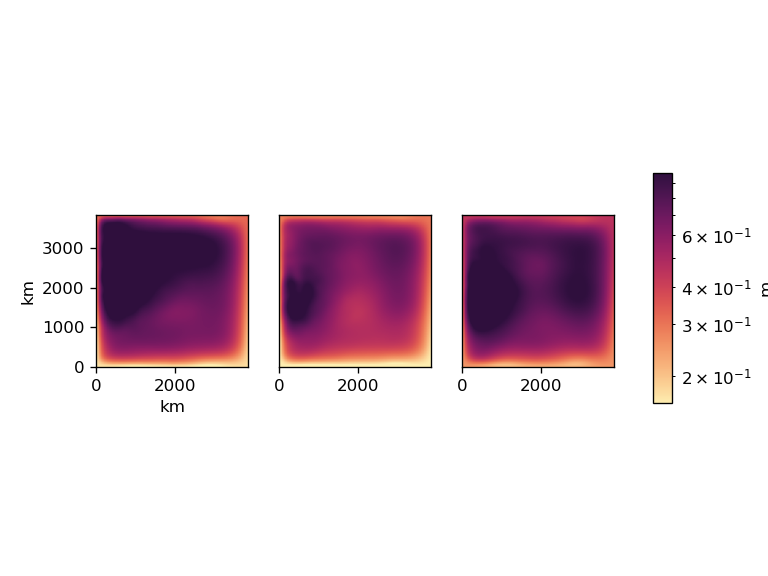

<ipython-input-4-d66fb066e4c4>:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(getattr(ds[var], func)(dim='time'), cmap=cmaps[func], **args[func],
<ipython-input-4-d66fb066e4c4>:20: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(getattr(ds[var], func)(dim='time'), cmap=cmaps[func], **args[func],
<ipython-input-4-d66fb066e4c4>:20: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(getattr(ds[var], func)(dim='time'), cmap=cmaps[f

In [8]:
if choice == 14:
    ds1 = xr.open_zarr(os.path.join(path_to_data, list_of_plots[5][0]))
    ds2 = xr.open_zarr(os.path.join(path_to_data, list_of_plots[6][0]))
    ds1 = ds1.rename(dict(r2_1pctC02_month='r2_control_month'))
    ds = ds1 - ds2
    func = list_of_plots[7][1]
    plot_args = list_of_plots[7][2]
    plot_args['vmin'] = -0.1
    plot_args['vmax'] = 0.1
else:
    ds = xr.open_zarr(os.path.join(path_to_data, list_of_plots[choice][0]))
    func = list_of_plots[choice][1]
    plot_args = list_of_plots[choice][2]

# For the kE time series re-order as in paper
if choice == 4:
    ds = ds[['low_rez_0', 'low_rez_1', 'low_rez_2', 'low_rez_3', 'high_rez']]

# Change the sign for dataset 6, as I changed the sign by mistake when saving...
if choice == 7:
    ds = -ds

#plt.style.use("seaborn-dark")
uv_plotter.margin = 10
if func == uv_plotter.plot:
    print('ok')
    for key in ds:
        print(key)
        ax = func(ds[key], borders_color='black', **plot_args)
        ax.coastlines(color='white')
else:
    func(ds.load())

In [9]:
plt.savefig(list_of_plots[choice][0] + '_Laure.jpg', dpi=400)

/ext3/miniconda3/envs/analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
plt.savefig('r2_control_month_y.jpg', dpi=400)

In [11]:
ds

<xarray.Dataset>
Dimensions:    (time: 3599, x: 96, y: 96)
Coordinates:
  * time       (time) float64 8.584e+04 1.722e+05 ... 3.107e+08 3.108e+08
  * x          (x) float64 2e+04 6e+04 1e+05 ... 3.74e+06 3.78e+06 3.82e+06
  * y          (y) float64 2e+04 6e+04 1e+05 ... 3.74e+06 3.78e+06 3.82e+06
Data variables:
    high_rez   (y, x, time) float64 -0.02526 -0.0269 -0.02708 ... 0.1493 0.2022
    low_rez_0  (time, y, x) float64 0.004493 0.002024 ... 0.1798 0.1783
    low_rez_1  (time, y, x) float64 0.002879 0.0006572 ... 0.01557 0.01781
    low_rez_2  (time, y, x) float64 0.003269 -0.0004145 ... -0.2851 -0.2859
    low_rez_3  (time, y, x) float64 0.005626 0.002861 ... -0.4476 -0.4495